In [66]:
%matplotlib ipympl

In [67]:
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist, plot_bode
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import pandas as pd

In [68]:
#My written functions
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def give_SSv(zexp,zmodel,wt,num):
    #zwt=give_weights2(zmodel,wt=wt)
    zexpr=np.real(zexp)
    zmodelr=np.real(zmodel)
    zexpj=-np.imag(zexp)
    zmodelj=-np.imag(zmodel)
    if(wt=="unit" or wt==""):
       SSv=(1/(2*len(zexp)-num))*np.sum((zexpr-zmodelr)**2+(zexpj-zmodelj)**2)
    elif(wt=="mod"):
       SSv=(1/(2*len(zexp)-num))*np.sum(((zexpr-zmodelr)/np.abs(zmodel))**2+((zexpj-zmodelj)/np.abs(zmodel))**2)
    elif(wt=="prop"):
       SSv=(1/(2*len(zexp)-num))*np.sum(((zexpr-zmodelr)/(zmodelr))**2+((zexpj-zmodelj)/(zmodelr))**2)
    return SSv

def give_SS(zexp,zmodel,wt):
     #zwt=give_weights2(zmodel,wt=wt)
     #zwt=give_weights(zmodel,wt=wt)
     zexpr=np.real(zexp)
     zmodelr=np.real(zmodel)
     zexpj=-np.imag(zexp)
     zmodelj=-np.imag(zmodel)
     if(wt=="unit" or wt==""):
       SS=np.sum((zexpr-zmodelr)**2+(zexpj-zmodelj)**2)
     elif(wt=="mod"):
       SS=np.sum(((zexpr-zmodelr)/np.abs(zmodel))**2+((zexpj-zmodelj)/np.abs(zmodel))**2)
     elif(wt=="prop"):
       SS=np.sum(((zexpr-zmodelr)/(zmodelr))**2+((zexpj-zmodelj)/(zmodelr))**2)
     return SS

In [69]:
@element(num_params=7, units=["Ohm", "Ohm", "Ohm", "","", "F",""],overwrite=True)
def TLMthreeNew(p, f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, R3, delta1, delta2, Q, alpha = p[0], p[1], p[2],p[3], p[4], p[5], p[6]
    delta3=1-delta1-delta2
    delta2=delta2
    k12=R2/R1
    k13=R3/R1
    Rion1=R1
    Rion2=R2
    Rion3=R3
    CTotal1=Q
    CTotal2=Q
    CTotal3=Q
    wc1=1/(Rion1*CTotal1)
    wc2=1/(Rion2*CTotal2)
    wc3=1/(Rion3*CTotal3)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    S3=np.sqrt((omega*1j)**alpha/wc3)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)
    C3=1/np.tanh(delta3*S3)

    Z=2*(R1)*((S1*S3*C1*k12**2+S2*C2*(S1*C1*C3*k13+S3)*k12+S2**2*C3*k13)/(S1*(S3*S1*k12**2+S2*C2*(S3*C1+S1*C3*k13)*k12+S2**2*C1*C3*k13)))
    
    return Z

@element(num_params=7, units=["Ohm", "Ohm", "Ohm", "","", "F",""],overwrite=True)
def TLMthreeNewRQNormalRref(p, f):
    omega = 2 * np.pi * np.array(f)
    t1, t2, t3,t3Q0, delta1, delta2, alpha = p[0], p[1], p[2],p[3], p[4], p[5], p[6]
    delta3=1-delta1-delta2
    delta2=delta2
    Rref=200
    Q=t3Q0/t3*1e-4
    R1=t1*Rref
    R2=t2*Rref
    R3=t3*Rref
    k12=R2/R1
    k13=R3/R1
    wc1=1/(R1*Q)
    wc2=1/(R2*Q)
    wc3=1/(R3*Q)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    S3=np.sqrt((omega*1j)**alpha/wc3)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)
    C3=1/np.tanh(delta3*S3)

    Z=2*(R1)*((S1*S3*C1*k12**2+S2*C2*(S1*C1*C3*k13+S3)*k12+S2**2*C3*k13)/(S1*(S3*S1*k12**2+S2*C2*(S3*C1+S1*C3*k13)*k12+S2**2*C1*C3*k13)))

    return Z

In [70]:
c0=CustomCircuit(initial_guess=[6,3,2,2,0.3,0.1,1],circuit='TLMthreeNewRQNormalRref')
freq = np.logspace(3,-3,num=100)
z0 = c0.predict(freq)
noise=0.01
z1=add_noise(z0,0.0)
z2=add_noise(z0,0.01)
z3=add_noise(z0,0.05)
#z1=add_noise(z0,0.05)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


In [71]:
idx=int(len(freq)/2)
print(idx)
z1_for_cpe=z1[idx:len(freq)-1]
cgcpe1=CustomCircuit(initial_guess=[1e-4,0.95],circuit="CPE")
cgcpe1.fit(freq[idx:len(freq)-1],z1_for_cpe)
p_gs1=cgcpe1.parameters_
Q_gs1=p_gs1[0]
alpha_gs1=p_gs1[1]
print(Q_gs1,alpha_gs1)

z2_for_cpe=z2[idx:len(freq)-1]
cgcpe2=CustomCircuit(initial_guess=[1e-4,0.95],circuit="CPE")
cgcpe2.fit(freq[idx:len(freq)-1],z2_for_cpe)
p_gs2=cgcpe2.parameters_
Q_gs2=p_gs2[0]
alpha_gs2=p_gs2[1]
print(Q_gs2,alpha_gs2)

z3_for_cpe=z3[idx:len(freq)-1]
cgcpe3=CustomCircuit(initial_guess=[1e-4,0.95],circuit="CPE")
cgcpe3.fit(freq[idx:len(freq)-1],z3_for_cpe)
p_gs3=cgcpe1.parameters_
Q_gs3=p_gs3[0]
alpha_gs3=p_gs3[1]
print(Q_gs3,alpha_gs3)

#param_guess1=[6,5,5,0.4,0.17,Q_gs1/1e-4,alpha_gs1]
param_guess1=[6,5,4,4*Q_gs1/1e-4,0.17,0.5,alpha_gs1]
param_guess2=[6,5,4,4*Q_gs2/1e-4,0.17,0.5,alpha_gs2]
param_guess3=[6,5,4,4*Q_gs3/1e-4,0.17,0.5,alpha_gs3]

cg1=CustomCircuit(initial_guess=param_guess1,circuit='TLMthreeNewRQNormalRref')
cg2=CustomCircuit(initial_guess=param_guess2,circuit='TLMthreeNewRQNormalRref')
cg3=CustomCircuit(initial_guess=param_guess3,circuit='TLMthreeNewRQNormalRref')
# fit1=cg.fit(freq,z0,sigma=give_weights(z0,"mod"),bounds=(0,[np.inf,np.inf,np.inf,1,1,np.inf,1]))
# zfit1=fit1.predict(freq)



50
4.9944366000931997e-05 0.9997524614307528
4.9838879511895956e-05 0.9999999999999317
4.9944366000931997e-05 0.9997524614307528


In [72]:
# print(fit1)
# fig, ax=plt.subplots()
# plot_nyquist(zfit1,ax=ax)
# plot_nyquist(z0,ax=ax)
# ax.set_xlim(0,3*np.maximum(np.max(np.real(z0)),np.max(np.imag(z0))))

In [73]:
# def plotter_for_three(freq,circuit0,zin,circuitg,wt):
    
#     c0=circuit0
#     z0=c0.predict(freq)
    
#     cg=circuitg
#     cf=cg.fit(freq,zin,sigma=give_weights(zin,wt),bounds=(0,[np.inf,np.inf,np.inf,1,1,np.inf,1]))
#     zf=cf.predict(freq)

#     p0=c0.initial_guess
#     R1_0, R2_0, R3_0, delta1_0, delta2_0, Q_0, alpha_0 = p0[0], p0[1], p0[2],p0[3], p0[4], p0[5], p0[6]

#     pf=cf.parameters_
#     R1_f, R2_f, R3_f, delta1_f, delta2_f, Q_f, alpha_f = pf[0], pf[1], pf[2],pf[3], pf[4], pf[5], pf[6]

#     linewidth=1
#     ticksize=6
#     color_actual="green"
#     color_noise="red"
#     color_fitted="blue"

#     fig = plt.figure(f"Results at δ1={delta1_0} and δ2={delta2_0}")
#     fig.set_size_inches(10,6)
    
#     #profile fit and profile original
#     ax1= fig.add_subplot(2,3,2)
    # ax1.plot([0,delta1_0,delta1_0,delta2_0,delta2_0,1],[R1_0,R1_0,R2_0,R2_0,R3_0,R3_0],linewidth=linewidth,color=color_actual,label="Actual")
    # ax1.plot([0,delta1_f,delta1_f,delta2_f,delta2_f,1],[R1_f,R1_f,R2_f,R2_f,R3_f,R3_f],linewidth=linewidth,color=color_fitted,label="Fitted")
#     ax1.tick_params(labelsize=ticksize)
#     ax1.axvline(x=delta1_0,ls="--",linewidth=0.6,color=color_actual)
#     ax1.axvline(x=delta2_0,ls="--",linewidth=0.6,color=color_actual)
#     ax1.axvline(x=delta1_f,ls="--",linewidth=0.6,color=color_fitted)
#     ax1.axvline(x=delta2_f,ls="--",linewidth=0.6,color=color_fitted)
#     ax1.set_ylabel("R1 / R2 / R3 (Ω)")
#     ax1.set_xlabel("δ")
#     ax1.set_xmargin(0)
#     ax1.legend()

#     xylim=max(give_xylim(zin,zf),give_xylim(zin,z0))

#     if xylim%1000>=1:
#         units="kΩ"
#         factor=1000
#     else:
#         units="Ω"
#         factor=1

#     #nyquist plot 
#     ax2=fig.add_subplot(2,3,3)
#     ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
#     ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
#     plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_nyquist(zin/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_nyquist(zf/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)
#     #inset_for_nyquist_plot
#     ax2_inset=ax2.inset_axes(bounds=[0.4,0.4,0.5,0.5])
#     plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_nyquist(zin/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_nyquist(zf/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)    

#     f_c=1/(R1_0*Q_0)
#     idx=find_index_of_nearest(freq,f_c)
#     z_c=c0.predict([freq[idx]])

#     xylim=np.real(1.2*np.real(z_c))
#     ax2_inset.set_xlim(0,xylim/factor)
#     ax2_inset.set_ylim(0,xylim/factor)
#     ax2_inset.set_xlabel("")
#     ax2_inset.set_ylabel("")
#     ax2.indicate_inset_zoom(ax2_inset)

#     #bode plots
#     ax3a=fig.add_subplot(2,3,5)
#     ax3b=fig.add_subplot(2,3,6)
#     plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_bode(freq,zin/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_bode(freq,zf/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)


#     pf[0]=np.around(pf[0],decimals=0,out=None)
#     pf[1]=np.around(pf[1],decimals=0,out=None)
#     pf[2]=np.around(pf[2],decimals=0,out=None)
#     pf[3]=np.around(pf[3],decimals=3,out=None)
#     pf[4]=np.around(pf[4],decimals=3,out=None)
#     pf[5]=np.around(pf[5],decimals=6,out=None)
#     pf[6]=np.around(pf[6],decimals=3,out=None)

#     p0[0]=np.around(p0[0],decimals=0,out=None)
#     p0[1]=np.around(p0[1],decimals=0,out=None)
#     p0[2]=np.around(p0[2],decimals=0,out=None)
#     p0[3]=np.around(p0[3],decimals=3,out=None)
#     p0[4]=np.around(pf[4],decimals=3,out=None)
#     p0[5]=np.around(pf[5],decimals=6,out=None)
#     p0[6]=np.around(pf[6],decimals=3,out=None)

#     data =np.array([p0,pf, (p0-pf)*100/(p0)])
#     #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
#     ax4=fig.add_subplot(1,3,1)
#     ax4.set_axis_off()
#     pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted","% Error"],rowLabels=["R1","R2","R3","δ1","δ2","Q","α"],loc="center")
#     pm_table.auto_set_font_size(False)
#     pm_table.set_fontsize(10)
#     plt.savefig("ggg.png")

    

In [74]:
def plotter_for_three(freq,circuit0,zin1,zin2,zin3,circuitg1,circuitg2,circuitg3,wt):
    
    Rref=200
    c0=circuit0
    z0=c0.predict(freq)
    cg1=circuitg1
    cg2=circuitg2
    cg3=circuitg3
    cf1=cg1.fit(freq,zin1,sigma=give_weights(zin1,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    #print(cf1)
    cf2=cg2.fit(freq,zin2,sigma=give_weights(zin2,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    cf3=cg3.fit(freq,zin3,sigma=give_weights(zin3,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    #print(cg3)

    zf1=cf1.predict(freq)
    zf2=cf2.predict(freq)
    zf3=cf3.predict(freq)

    p0=c0.initial_guess
    t1_0, t2_0, t3_0, t3Q0_0, delta1_0, delta2_0, alpha_0 = p0[0], p0[1], p0[2],p0[3], p0[4], p0[5], p0[6]
    Q_0=1e-4*t3Q0_0/t3_0


    pg=cg1.initial_guess
    t1_g, t2_g, t3_g, t3Q0_g, delta1_g, delta2_g, alpha_g = pg[0], pg[1], pg[2],pg[3], pg[4], pg[5], pg[6] 
    Q_g=1e-4*t3Q0_g/t3_g

    pf1=cg1.parameters_
    t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1 = pf1[0], pf1[1], pf1[2],pf1[3], pf1[4], pf1[5], pf1[6]
    Q_f1=1e-4*t3Q0_f1/t3_f1  
 
    pf2=cg2.parameters_
    t1_f2, t2_f2, t3_f2, t3Q0_f2, delta1_f2, delta2_f2, alpha_f2 = pf2[0], pf2[1], pf2[2],pf2[3], pf2[4], pf2[5], pf2[6] 
    Q_f2=1e-4*t3Q0_f2/t3_f2 

    pf3=cf3.parameters_
    t1_f3, t2_f3, t3_f3, t3Q0_f3, delta1_f3, delta2_f3, alpha_f3 = pf3[0], pf3[1], pf3[2],pf3[3], pf3[4], pf3[5], pf3[6] 
    Q_f3=1e-4*t3Q0_f3/t3_f3 

    linewidth=1
    linewidth_actual=3
    ticksize=6
    color_actual="red"
    color_noise1=[0,0.5,0]
    color_noise2=[0.2,0.4,0.2]
    color_noise3=[0,0.65,0.4]
    color_fitted1=[0,0,1]
    color_fitted2=[0.4,0.58,0.65]
    color_fitted3=[0,0.6,1]

    fig = plt.figure(f"Results at δ1={delta1_0} δ2={delta2_0}")
    fig.set_size_inches(10,6)
    
    alpha=0.3
    #profile fit and profile original
    ax1=plt.subplot2grid((5,4),(1,0),rowspan=2,colspan=2)
    #ax1= fig.add_subplot(2,4,1)
    ax1.plot([0,delta1_0,delta1_0,delta2_0+delta1_0,delta2_0+delta1_0,1],[t1_0,t1_0,t2_0,t2_0,t3_0,t3_0],linewidth=linewidth_actual,color=color_actual,label="Actual")
    ax1.plot([0,delta1_f1,delta1_f1,delta2_f1+delta1_f1,delta2_f1+delta1_f1,1],[t1_f1,t1_f1,t2_f1,t2_f1,t3_f1,t3_f1],linewidth=linewidth,color=color_fitted1,label="Fitted 1")
    ax1.plot([0,delta1_f2,delta1_f2,delta2_f2+delta1_f2,delta2_f2+delta1_f2,1],[t1_f2,t1_f2,t2_f2,t2_f2,t3_f2,t3_f2],linewidth=linewidth,color=color_fitted2,label="Fitted 2")
    ax1.plot([0,delta1_f3,delta1_f3,delta2_f3+delta1_f3,delta2_f3+delta1_f3,1],[t1_f3,t1_f3,t2_f3,t2_f3,t3_f3,t3_f3],linewidth=linewidth,color=color_fitted3,label="Fitted 3")

    delta3_0=1-delta1_0-delta2_0
    delta3_f1=1-delta1_f1-delta2_f1
    delta3_f2=1-delta1_f2-delta2_f2
    delta3_f3=1-delta1_f3-delta2_f3
    ax1.tick_params(labelsize=ticksize)
    ax1.text(-0.1, 1.1, "(A)", transform=ax1.transAxes, size=10, weight='bold')
    # ax1.axvline(x=delta1_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta2_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta3_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta1_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta2_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta3_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta1_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta2_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta3_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta1_f3,ls="--",linewidth=0.3,color=color_fitted3)
    # ax1.axvline(x=delta2_f3,ls="--",linewidth=0.3,color=color_fitted3)
    # ax1.axvline(x=delta3_f3,ls="--",linewidth=0.3,color=color_fitted3)
    ax1.set_ylabel("τ1 / τ2 / τ3 (Ω)") 
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    leg=ax1.legend()
    for line in leg.get_lines():
        line.set_linewidth(3)

    xylim=max(give_xylim(zin1,zf1),give_xylim(zin1,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    #ax2=fig.add_subplot(1,2,2)
    ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
    ax2.text(-0.1, 1.05, "(B)", transform=ax2.transAxes, size=10, weight='bold')
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf2/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    ax2_inset=ax2.inset_axes(bounds=[0.4,0.1,0.5,0.5])
    plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(zin2/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(zf1/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(Rref*t1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim_inset=1.2*np.real(z_c)
    ax2_inset.set_xlim(0,xylim_inset/factor)
    ax2_inset.set_ylim(0,xylim_inset/factor)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")
    ax2.indicate_inset_zoom(ax2_inset)

    ax2_inset1=ax2.inset_axes(bounds=[0.4,0.7,0.3,0.2])
    plot_nyquist(zin1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(Rref*t1_0*Q_0)

    f_c=freq[len(freq)-1]*2
    idx=find_index_of_nearest(freq,f_c)
    z0c=c0.predict([freq[idx]])
    zfc1=cf1.predict([freq[idx]])
    zfc2=cf2.predict([freq[idx]])
    zfc3=cf3.predict([freq[idx]])
    
    max_xlim_inset=np.max([np.real(z0c),np.real(zfc1),np.real(zfc2),np.real(zfc3)])
    max_ylim_inset=np.max([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2),-np.imag(zfc3)])
    min_xlim_inset=np.min([np.real(z0c),np.real(zfc1),np.real(zfc2),np.real(zfc3)])
    min_ylim_inset=np.min([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2),-np.imag(zfc3)])
    gap=(max_xlim_inset-min_xlim_inset)/factor
    print(gap)
    # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_ylim(ylim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_xlim(min_xlim_inset/factor-0.1*max_xlim_inset/factor,1.1*max_xlim_inset/factor)
    # ax2_inset1.set_ylim(min_ylim_inset/factor-0.1*max_xlim_inset/factor,min_ylim_inset/factor+0.1*max_xlim_inset/factor)
    
    ax2_inset1.set_xlim(min_xlim_inset/factor-2*gap,2*gap+max_xlim_inset/factor)
    ax2_inset1.set_ylim(min_ylim_inset/factor-2*gap,min_ylim_inset/factor+2*gap)
    ax2_inset1.set_aspect("equal")
    ax2_inset1.set_xlabel("")
    ax2_inset1.set_ylabel("")
    ax2_inset1.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2_inset1.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2.indicate_inset_zoom(ax2_inset1)


    #bode plots
    #ax3a=fig.add_subplot(2,4,5)
    #ax3b=fig.add_subplot(2,4,6)
    ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
    ax3b.text(-0.1, 1.1, "(D)", transform=ax3b.transAxes, size=10, weight='bold')
    plot_bode(freq,zin1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zin3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zf1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)

    ax3a.clear()
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    dip_angle=np.min(-np.angle((np.hstack((zf1,zf2,zf3))),deg=True))
    angle_z0=-np.angle(z0,deg=True)

    idx=find_index_of_nearest(angle_z0,dip_angle)
    angle_z1=-np.angle(zf1,deg=True)
    angle_z2=-np.angle(zf2,deg=True)
    angle_z3=-np.angle(zf3,deg=True)
    
    print("dip_angle",dip_angle)
    ax3a.plot(freq,angle_z1,color=color_fitted1)
    ax3a.plot(freq,angle_z3,color=color_fitted2)
    ax3a.plot(freq,angle_z2,color=color_fitted3)
    ax3a.plot(freq,angle_z0,color=color_actual,linewidth=0.5)
    
    ax3a.set_xlabel('f [Hz]', fontsize=10)
    ax3a.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10)
    ax3a.set_xlim(freq[idx]/50,freq[0])
    ax3a.set_ylim(angle_z0[idx]-5,angle_z0[idx]+10)
    ax3a.set_xscale('log')
    ax3a.grid(visible=True)

    SSv1=give_SSv(zin1,zf1,wt,7)
    SSv2=give_SSv(zin2,zf2,wt,7)
    SSv3=give_SSv(zin3,zf3,wt,7)
    
    SS1=give_SS(zin1,zf1,wt)
    SS2=give_SS(zin2,zf2,wt)
    SS3=give_SS(zin3,zf3,wt)
    

    p0_table=np.array([t1_0, t2_0, t3_0, delta1_0, delta2_0, Q_0, alpha_0,0,0])
    pf1_table=np.array([t1_f1, t2_f1, t3_f1, delta1_f1, delta2_f1, Q_f1, alpha_f1,SS1,SSv1])
    pf2_table=np.array([t1_f2, t2_f2, t3_f2, delta1_f2, delta2_f2, Q_f2, alpha_f2,SS2,SSv2])
    pf3_table=np.array([t1_f3, t2_f3, t3_f3, delta1_f3, delta2_f3, Q_f3, alpha_f3,SS3,SSv3])
    pg_table=np.array([t1_g, t2_g, t3_g, delta1_g, delta2_g, Q_g, alpha_g])


    percent_err1=(pf1_table-p0_table)*100/(p0_table)
    percent_err2=(pf2_table-p0_table)*100/(p0_table)
    percent_err3=(pf3_table-p0_table)*100/(p0_table)

    percent_err_table1=percent_err1
    percent_err_table2=percent_err2
    percent_err_table3=percent_err3

    sd1=cf1.conf_
    sd2=cf2.conf_
    sd3=cf3.conf_
    p0_table2=[t1_0, t2_0, t3_0, t3Q0_0, delta1_0, delta2_0, alpha_0]
    pf1_table2=[t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1]
    sd1_table2=sd1
    pf2_table2=[t1_f2, t2_f2, t3_f2, t3Q0_f2, delta1_f2, delta2_f2, alpha_f2]
    sd2_table2=sd2
    pf3_table2=[t1_f3, t2_f3, t3_f3, t3Q0_f3, delta1_f3, delta2_f3, alpha_f3]
    sd3_table2=sd3
    pg_table2=[t1_g, t2_g, t3_g, t3Q0_g, delta1_g, delta2_g, alpha_g]

    def make_values_for_table(arr):
        for i in range(0,len(arr)):
            arr[i]="{:.2e}".format(arr[i])
        return arr
    
    pf1_table=make_values_for_table(pf1_table)
    pf2_table=make_values_for_table(pf2_table)
    pf3_table=make_values_for_table(pf3_table)
    p0_table=make_values_for_table(p0_table)
    pg_table=make_values_for_table(pg_table)
    percent_err_table1=make_values_for_table(percent_err_table1)
    percent_err_table2=make_values_for_table(percent_err_table2)
    percent_err_table3=make_values_for_table(percent_err_table3)

    data =np.array([p0_table,pf1_table,percent_err_table1,pf2_table,percent_err_table2,pf3_table,percent_err_table3])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    pf1_table2=make_values_for_table(pf1_table2)
    pf2_table2=make_values_for_table(pf2_table2)
    pf3_table2=make_values_for_table(pf3_table2)
    p0_table2=make_values_for_table(p0_table2)
    pg_table2=make_values_for_table(pg_table2)
    sd1_table2=make_values_for_table(sd1_table2)
    sd2_table2=make_values_for_table(sd2_table2)
    sd3_table2=make_values_for_table(sd3_table2)
    data2=np.array([p0_table2,pf1_table2,sd1_table2,pf2_table2,sd2_table2,pf3_table2,sd3_table2])
    
    ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)
    ax4.set_axis_off()
    colwidth=np.full((8),0.1) 
    #pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],colWidths=colwidth,rowLabels=["τ1","τ2","τ3","δ1","δ2","Q","α","SS","SSv"],loc="center") 
    #pm_table.auto_set_font_size(False)
    #pm_table.set_fontsize(8)
    pm_table_df=pd.DataFrame(np.transpose(data),columns=["Actual","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],index=["τ1","τ2","τ3","δ1","δ2","Q","α","SS","SSv"])

    pm_table_df2=pd.DataFrame(np.transpose(data2),columns=["Actual","Fitted 1","SD","Fitted 2","SD","Fitted 3","SD"],index=["τ1","τ2","τ3","τ3Q0","δ1","δ2","α"])

    with pd.ExcelWriter(f"SD t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.xlsx",mode="w",) as writer:
        pm_table_df2.to_excel(writer)

    with pd.ExcelWriter(f"Error t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.xlsx",mode="w",) as writer:
        pm_table_df.to_excel(writer)

    fig.tight_layout(pad=0.5)
    plt.savefig(f"fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png")

In [75]:
def plotter_for_three2(freq,circuit0,zin1,zin2,zin3,circuitg1,circuitg2,circuitg3,wt):
    
    Rref=200
    c0=circuit0
    z0=c0.predict(freq)
    cg1=circuitg1
    cg2=circuitg2
    # cg3=circuitg3
    cf1=cg1.fit(freq,zin1,sigma=give_weights(zin1,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    #print(cf1)
    cf2=cg2.fit(freq,zin2,sigma=give_weights(zin2,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    # cf3=cg3.fit(freq,zin3,sigma=give_weights(zin3,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    #print(cg3)

    zf1=cf1.predict(freq)
    zf2=cf2.predict(freq)
    # zf3=cf3.predict(freq)

    p0=c0.initial_guess
    t1_0, t2_0, t3_0, t3Q0_0, delta1_0, delta2_0, alpha_0 = p0[0], p0[1], p0[2],p0[3], p0[4], p0[5], p0[6]
    Q_0=1e-4*t3Q0_0/t3_0


    pg=cg1.initial_guess
    t1_g, t2_g, t3_g, t3Q0_g, delta1_g, delta2_g, alpha_g = pg[0], pg[1], pg[2],pg[3], pg[4], pg[5], pg[6] 
    Q_g=1e-4*t3Q0_g/t3_g

    pf1=cg1.parameters_
    t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1 = pf1[0], pf1[1], pf1[2],pf1[3], pf1[4], pf1[5], pf1[6]
    Q_f1=1e-4*t3Q0_f1/t3_f1  
 
    pf2=cg2.parameters_
    t1_f2, t2_f2, t3_f2, t3Q0_f2, delta1_f2, delta2_f2, alpha_f2 = pf2[0], pf2[1], pf2[2],pf2[3], pf2[4], pf2[5], pf2[6] 
    Q_f2=1e-4*t3Q0_f2/t3_f2 

    # pf3=cf3.parameters_
    # t1_f3, t2_f3, t3_f3, t3Q0_f3, delta1_f3, delta2_f3, alpha_f3 = pf3[0], pf3[1], pf3[2],pf3[3], pf3[4], pf3[5], pf3[6] 
    # Q_f3=1e-4*t3Q0_f3/t3_f3 

    linewidth=1
    linewidth_actual=3
    ticksize=6
    color_actual="red"
    color_noise1=[0,0.5,0]
    color_noise2=[0.2,0.4,0.2]
    color_noise3=[0,0.65,0.4]
    color_fitted1=[0,0,1]
    color_fitted2=[0.4,0.58,0.65]
    color_fitted3=[0,0.6,1]

    fig = plt.figure(f"Results at δ1={delta1_0} δ2={delta2_0}")
    fig.set_size_inches(10,6)
    
    alpha=0.3
    #profile fit and profile original
    #ax1=plt.subplot2grid((5,4),(1,0),rowspan=2,colspan=2)
    fig2, ax1=plt.subplots()
    #ax1= fig.add_subplot(2,4,1)
    ax1.plot([0,delta1_0,delta1_0,delta2_0+delta1_0,delta2_0+delta1_0,1],[t1_0,t1_0,t2_0,t2_0,t3_0,t3_0],linewidth=linewidth_actual,color=color_actual,label="Actual")
    ax1.plot([0,delta1_f1,delta1_f1,delta2_f1+delta1_f1,delta2_f1+delta1_f1,1],[t1_f1,t1_f1,t2_f1,t2_f1,t3_f1,t3_f1],linewidth=linewidth,color=color_fitted1,label="Fit (clean)")
    #ax1.plot([0,delta1_f2,delta1_f2,delta2_f2+delta1_f2,delta2_f2+delta1_f2,1],[t1_f2,t1_f2,t2_f2,t2_f2,t3_f2,t3_f2],linewidth=linewidth,color=color_fitted2,label="Fit (noise)")
    # ax1.plot([0,delta1_f3,delta1_f3,delta2_f3+delta1_f3,delta2_f3+delta1_f3,1],[t1_f3,t1_f3,t2_f3,t2_f3,t3_f3,t3_f3],linewidth=linewidth,color=color_fitted3,label="Fitted 3")
    ax1.tick_params(labelsize=13)
    delta3_0=1-delta1_0-delta2_0
    delta3_f1=1-delta1_f1-delta2_f1
    delta3_f2=1-delta1_f2-delta2_f2
    # delta3_f3=1-delta1_f3-delta2_f3
    #ax1.tick_params(labelsize=ticksize)
    #fig2.savefig(f"night fig t1={t1_0} t2={t2_0} δ1={delta1_0} δ1={delta1_f1}.png",format="png",dpi=1200)
    #ax1.text(-0.1, 1.1, "(A)", transform=ax1.transAxes, size=10, weight='bold')
    # ax1.axvline(x=delta1_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta2_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta3_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta1_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta2_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta3_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta1_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta2_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta3_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta1_f3,ls="--",linewidth=0.3,color=color_fitted3)
    # ax1.axvline(x=delta2_f3,ls="--",linewidth=0.3,color=color_fitted3)
    # ax1.axvline(x=delta3_f3,ls="--",linewidth=0.3,color=color_fitted3)
    ax1.set_ylabel("τ1 / τ2 / τ3 (Ω)",fontsize=18) 
    ax1.set_xlabel("δ",fontsize=18)
    ax1.set_xmargin(0)
    # leg=ax1.legend()
    # for line in leg.get_lines():
    #     line.set_linewidth(3)

    fig2.savefig(f"night fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)
    xylim=max(give_xylim(zin1,zf1),give_xylim(zin1,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    #ax2=fig.add_subplot(1,2,2)
    ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
    ax2.text(-0.1, 1.05, "(B)", transform=ax2.transAxes, size=10, weight='bold')
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf2/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    # plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    # ax2_inset=ax2.inset_axes(bounds=[0.4,0.1,0.5,0.5])
    fg2, ax2_inset = plt.subplots()
    # plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=alpha)
    # plot_nyquist(zin2/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize,alpha=alpha)
    # plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_actual,linewidth=linewidth_actual,marker="^",ms=3)
    plot_nyquist(zf1/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_fitted1,linewidth=linewidth,marker="o",ms=2)    
    
    #plot_nyquist(zf2/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    # plot_nyquist(zf3/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    
    f_c=1/(Rref*t1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim_inset=1.2*np.real(z_c)
    ax2_inset.set_xlim(0,xylim_inset/factor)
    ax2_inset.set_ylim(0,xylim_inset/factor)
    # ax2_inset.set_xlabel("")
    # ax2_inset.set_ylabel("")
    plt.tight_layout()
    fg2.savefig(f"night nyquist fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)
    
    ax2.indicate_inset_zoom(ax2_inset)
    ax2_inset1=ax2.inset_axes(bounds=[0.4,0.7,0.3,0.2])
    plot_nyquist(zin1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    # plot_nyquist(zin3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    # plot_nyquist(zf3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(Rref*t1_0*Q_0)

    f_c=freq[len(freq)-1]*2
    idx=find_index_of_nearest(freq,f_c)
    z0c=c0.predict([freq[idx]])
    zfc1=cf1.predict([freq[idx]])
    zfc2=cf2.predict([freq[idx]])
    # zfc3=cf3.predict([freq[idx]])
    
    max_xlim_inset=np.max([np.real(z0c),np.real(zfc1),np.real(zfc2),])
    max_ylim_inset=np.max([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2)])
    min_xlim_inset=np.min([np.real(z0c),np.real(zfc1),np.real(zfc2)])
    min_ylim_inset=np.min([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2)])
    gap=(max_xlim_inset-min_xlim_inset)/factor
    print(gap)
    # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_ylim(ylim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_xlim(min_xlim_inset/factor-0.1*max_xlim_inset/factor,1.1*max_xlim_inset/factor)
    # ax2_inset1.set_ylim(min_ylim_inset/factor-0.1*max_xlim_inset/factor,min_ylim_inset/factor+0.1*max_xlim_inset/factor)
    
    ax2_inset1.set_xlim(min_xlim_inset/factor-2*gap,2*gap+max_xlim_inset/factor)
    ax2_inset1.set_ylim(min_ylim_inset/factor-2*gap,min_ylim_inset/factor+2*gap)
    ax2_inset1.set_aspect("equal")
    ax2_inset1.set_xlabel("")
    ax2_inset1.set_ylabel("")
    ax2_inset1.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2_inset1.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2.indicate_inset_zoom(ax2_inset1)


    #bode plots
    #ax3a=fig.add_subplot(2,4,5)
    #ax3b=fig.add_subplot(2,4,6)
    ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
    ax3b.text(-0.1, 1.1, "(D)", transform=ax3b.transAxes, size=10, weight='bold')
    plot_bode(freq,zin1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize,alpha=0.3)
    # plot_bode(freq,zin3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zf1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    # plot_bode(freq,zf3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)

    ax3a.clear()
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    dip_angle=np.min(-np.angle((np.hstack((zf1,zf2))),deg=True))
    angle_z0=-np.angle(z0,deg=True)

    idx=find_index_of_nearest(angle_z0,dip_angle)
    angle_z1=-np.angle(zf1,deg=True)
    #angle_z2=-np.angle(zf2,deg=True)
    # angle_z3=-np.angle(zf3,deg=True)
    
    print("dip_angle",dip_angle)
    fg3,ax3a=plt.subplots()
    ax3a.plot(freq,angle_z0,color=color_actual,linewidth=linewidth_actual,marker="^",ms=3)
    ax3a.plot(freq,angle_z1,color=color_fitted1,linewidth=linewidth,marker="o",ms=2)
    # ax3a.plot(freq,angle_z3,color=color_fitted2)
    #ax3a.plot(freq,angle_z2,color=color_fitted3)
    
    ax3a.set_xlabel('f [Hz]', fontsize=18)
    ax3a.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=18)
    ax3a.set_xlim(freq[idx]/50,freq[0])
    ax3a.set_ylim(angle_z0[idx]-5,angle_z0[idx]+10)
    ax3a.set_xscale('log')
    ax3a.grid(visible=True)
    ax3a.tick_params(labelsize=13)
    plt.tight_layout()
    fg3.savefig(f"night bbode fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)

    SSv1=give_SSv(zin1,zf1,wt,7)
    SSv2=give_SSv(zin2,zf2,wt,7)
    # SSv3=give_SSv(zin3,zf3,wt,7)
    
    SS1=give_SS(zin1,zf1,wt)
    SS2=give_SS(zin2,zf2,wt)
    # SS3=give_SS(zin3,zf3,wt)
    

    p0_table=np.array([t1_0, t2_0, t3_0, delta1_0, delta2_0, Q_0, alpha_0,0,0])
    pf1_table=np.array([t1_f1, t2_f1, t3_f1, delta1_f1, delta2_f1, Q_f1, alpha_f1,SS1,SSv1])
    pf2_table=np.array([t1_f2, t2_f2, t3_f2, delta1_f2, delta2_f2, Q_f2, alpha_f2,SS2,SSv2])
    # pf3_table=np.array([t1_f3, t2_f3, t3_f3, delta1_f3, delta2_f3, Q_f3, alpha_f3,SS3,SSv3])
    pg_table=np.array([t1_g, t2_g, t3_g, delta1_g, delta2_g, Q_g, alpha_g])


    percent_err1=(pf1_table-p0_table)*100/(p0_table)
    percent_err2=(pf2_table-p0_table)*100/(p0_table)
    # percent_err3=(pf3_table-p0_table)*100/(p0_table)

    percent_err_table1=percent_err1
    percent_err_table2=percent_err2
    # percent_err_table3=percent_err3

    sd1=cf1.conf_
    sd2=cf2.conf_
    # sd3=cf3.conf_
    p0_table2=[t1_0, t2_0, t3_0, t3Q0_0, delta1_0, delta2_0, alpha_0]
    pf1_table2=[t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1]
    sd1_table2=sd1
    pf2_table2=[t1_f2, t2_f2, t3_f2, t3Q0_f2, delta1_f2, delta2_f2, alpha_f2]
    sd2_table2=sd2
    # pf3_table2=[t1_f3, t2_f3, t3_f3, t3Q0_f3, delta1_f3, delta2_f3, alpha_f3]
    # sd3_table2=sd3
    pg_table2=[t1_g, t2_g, t3_g, t3Q0_g, delta1_g, delta2_g, alpha_g]

    def make_values_for_table(arr):
        for i in range(0,len(arr)):
            arr[i]="{:.2e}".format(arr[i])
        return arr
    
    pf1_table=make_values_for_table(pf1_table)
    pf2_table=make_values_for_table(pf2_table)
    # pf3_table=make_values_for_table(pf3_table)
    p0_table=make_values_for_table(p0_table)
    pg_table=make_values_for_table(pg_table)
    percent_err_table1=make_values_for_table(percent_err_table1)
    percent_err_table2=make_values_for_table(percent_err_table2)
    # percent_err_table3=make_values_for_table(percent_err_table3)

    data =np.array([p0_table,pf1_table,percent_err_table1,pf2_table,percent_err_table2])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    pf1_table2=make_values_for_table(pf1_table2)
    pf2_table2=make_values_for_table(pf2_table2)
    # pf3_table2=make_values_for_table(pf3_table2)
    p0_table2=make_values_for_table(p0_table2)
    pg_table2=make_values_for_table(pg_table2)
    sd1_table2=make_values_for_table(sd1_table2)
    sd2_table2=make_values_for_table(sd2_table2)
    # sd3_table2=make_values_for_table(sd3_table2)
    data2=np.array([p0_table2,pf1_table2,sd1_table2,pf2_table2,sd2_table2])
    
    ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)
    ax4.set_axis_off()
    colwidth=np.full((8),0.1) 
    #pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],colWidths=colwidth,rowLabels=["τ1","τ2","τ3","δ1","δ2","Q","α","SS","SSv"],loc="center") 
    #pm_table.auto_set_font_size(False)
    #pm_table.set_fontsize(8)
    pm_table_df=pd.DataFrame(np.transpose(data),columns=["Actual","Fit (clean)","% Error","Fit (noise)","% Error"],index=["τ1","τ2","τ3","δ1","δ2","Q","α","SS","SSv"])

    pm_table_df2=pd.DataFrame(np.transpose(data2),columns=["Actual","Fit (clean)","SD","Fit (noise)","SD"],index=["τ1","τ2","τ3","τ3Q0","δ1","δ2","α"])

    with pd.ExcelWriter(f"night SD t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.xlsx",mode="w",) as writer:
        pm_table_df2.to_excel(writer)

    with pd.ExcelWriter(f"night Error t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.xlsx",mode="w",) as writer:
        pm_table_df.to_excel(writer)

    fig.tight_layout(pad=0.5)
    

In [76]:
def plotter_for_three3(freq,circuit0,zin1,zin2,zin3,circuitg1,circuitg2,circuitg3,wt):
    
    Rref=200
    c0=circuit0
    z0=c0.predict(freq)
    cg1=circuitg1
    cg2=circuitg2
    # cg3=circuitg3
    cf1=cg1.fit(freq,zin1,sigma=give_weights(zin1,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    #print(cf1)
    cf2=cg2.fit(freq,zin2,sigma=give_weights(zin2,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    # cf3=cg3.fit(freq,zin3,sigma=give_weights(zin3,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    #print(cg3)

    zf1=cf1.predict(freq)
    zf2=cf2.predict(freq)
    # zf3=cf3.predict(freq)

    p0=c0.initial_guess
    t1_0, t2_0, t3_0, t3Q0_0, delta1_0, delta2_0, alpha_0 = p0[0], p0[1], p0[2],p0[3], p0[4], p0[5], p0[6]
    Q_0=1e-4*t3Q0_0/t3_0


    pg=cg1.initial_guess
    t1_g, t2_g, t3_g, t3Q0_g, delta1_g, delta2_g, alpha_g = pg[0], pg[1], pg[2],pg[3], pg[4], pg[5], pg[6] 
    Q_g=1e-4*t3Q0_g/t3_g

    pf1=cg1.parameters_
    t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1 = pf1[0], pf1[1], pf1[2],pf1[3], pf1[4], pf1[5], pf1[6]
    Q_f1=1e-4*t3Q0_f1/t3_f1  
 
    pf2=cg2.parameters_
    t1_f2, t2_f2, t3_f2, t3Q0_f2, delta1_f2, delta2_f2, alpha_f2 = pf2[0], pf2[1], pf2[2],pf2[3], pf2[4], pf2[5], pf2[6] 
    Q_f2=1e-4*t3Q0_f2/t3_f2 

    # pf3=cf3.parameters_
    # t1_f3, t2_f3, t3_f3, t3Q0_f3, delta1_f3, delta2_f3, alpha_f3 = pf3[0], pf3[1], pf3[2],pf3[3], pf3[4], pf3[5], pf3[6] 
    # Q_f3=1e-4*t3Q0_f3/t3_f3 

    linewidth=1
    linewidth_actual=3
    ticksize=6
    color_actual="red"
    color_noise1="black"
    color_noise2="green"
    color_noise3="blue"
    color_fitted1=color_noise1
    color_fitted2=color_noise2
    color_fitted3=color_noise3

    fig = plt.figure(f"Results at δ1={delta1_0} δ2={delta2_0}")
    fig.set_size_inches(10,6)
    
    alpha=0.3
    #profile fit and profile original
    #ax1=plt.subplot2grid((5,4),(1,0),rowspan=2,colspan=2)
    fig2, ax1=plt.subplots()
    #ax1= fig.add_subplot(2,4,1)
    ax1.plot([0,delta1_0,delta1_0,delta2_0+delta1_0,delta2_0+delta1_0,1],[t1_0,t1_0,t2_0,t2_0,t3_0,t3_0],linewidth=linewidth_actual,color=color_actual,label="Actual")
    #ax1.plot([0,delta1_f1,delta1_f1,delta2_f1+delta1_f1,delta2_f1+delta1_f1,1],[t1_f1,t1_f1,t2_f1,t2_f1,t3_f1,t3_f1],linewidth=linewidth,color=color_fitted1,label="Fit (clean)")
    ax1.plot([0,delta1_f2,delta1_f2,delta2_f2+delta1_f2,delta2_f2+delta1_f2,1],[t1_f2,t1_f2,t2_f2,t2_f2,t3_f2,t3_f2],linewidth=linewidth,color=color_fitted2,label="Fit (noise)")
    # ax1.plot([0,delta1_f3,delta1_f3,delta2_f3+delta1_f3,delta2_f3+delta1_f3,1],[t1_f3,t1_f3,t2_f3,t2_f3,t3_f3,t3_f3],linewidth=linewidth,color=color_fitted3,label="Fitted 3")
    ax1.tick_params(labelsize=13)
    delta3_0=1-delta1_0-delta2_0
    delta3_f1=1-delta1_f1-delta2_f1
    delta3_f2=1-delta1_f2-delta2_f2
    # delta3_f3=1-delta1_f3-delta2_f3
    #ax1.tick_params(labelsize=ticksize)
    #fig2.savefig(f"night fig t1={t1_0} t2={t2_0} δ1={delta1_0} δ1={delta1_f1}.png",format="png",dpi=1200)
    #ax1.text(-0.1, 1.1, "(A)", transform=ax1.transAxes, size=10, weight='bold')
    # ax1.axvline(x=delta1_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta2_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta3_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta1_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta2_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta3_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta1_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta2_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta3_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta1_f3,ls="--",linewidth=0.3,color=color_fitted3)
    # ax1.axvline(x=delta2_f3,ls="--",linewidth=0.3,color=color_fitted3)
    # ax1.axvline(x=delta3_f3,ls="--",linewidth=0.3,color=color_fitted3)
    ax1.set_ylabel("τ1 / τ2 / τ3 (Ω)",fontsize=18) 
    ax1.set_xlabel("δ",fontsize=18)
    ax1.set_xmargin(0)
    # leg=ax1.legend()
    # for line in leg.get_lines():
    #     line.set_linewidth(3)

    fig2.savefig(f"night2 noise={noise} fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)
    xylim=max(give_xylim(zin1,zf1),give_xylim(zin1,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    #ax2=fig.add_subplot(1,2,2)
    ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
    ax2.text(-0.1, 1.05, "(B)", transform=ax2.transAxes, size=10, weight='bold')
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf2/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    # plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    # ax2_inset=ax2.inset_axes(bounds=[0.4,0.1,0.5,0.5])
    fg2, ax2_inset = plt.subplots()
    # plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(zin2/factor,ax=ax2_inset,units=units,fmt="--",color="green",linewidth=0.2,marker='.',ms=2,alpha=0.6)
    # plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_actual,linewidth=linewidth_actual,marker="^",ms=3)
    #plot_nyquist(zf1/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_fitted1,linewidth=linewidth,marker="o",ms=2)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_fitted2,linewidth=linewidth,marker="X",ms=2)    
    
    # plot_nyquist(zf3/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    
    f_c=1/(Rref*t1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim_inset=1.5*np.real(z_c)
    ax2_inset.set_xlim(0,xylim_inset/factor)
    ax2_inset.set_ylim(0,xylim_inset/factor)
    # ax2_inset.set_xlabel("")
    # ax2_inset.set_ylabel("")
    plt.tight_layout()
    fg2.savefig(f"night2 nyquist noise={noise} fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)
    
    ax2.indicate_inset_zoom(ax2_inset)
    ax2_inset1=ax2.inset_axes(bounds=[0.4,0.7,0.3,0.2])
    plot_nyquist(zin1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    # plot_nyquist(zin3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    # plot_nyquist(zf3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(Rref*t1_0*Q_0)

    f_c=freq[len(freq)-1]*2
    idx=find_index_of_nearest(freq,f_c)
    z0c=c0.predict([freq[idx]])
    zfc1=cf1.predict([freq[idx]])
    zfc2=cf2.predict([freq[idx]])
    # zfc3=cf3.predict([freq[idx]])
    
    max_xlim_inset=np.max([np.real(z0c),np.real(zfc1),np.real(zfc2),])
    max_ylim_inset=np.max([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2)])
    min_xlim_inset=np.min([np.real(z0c),np.real(zfc1),np.real(zfc2)])
    min_ylim_inset=np.min([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2)])
    gap=(max_xlim_inset-min_xlim_inset)/factor
    print(gap)
    # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_ylim(ylim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_xlim(min_xlim_inset/factor-0.1*max_xlim_inset/factor,1.1*max_xlim_inset/factor)
    # ax2_inset1.set_ylim(min_ylim_inset/factor-0.1*max_xlim_inset/factor,min_ylim_inset/factor+0.1*max_xlim_inset/factor)
    
    ax2_inset1.set_xlim(min_xlim_inset/factor-2*gap,2*gap+max_xlim_inset/factor)
    ax2_inset1.set_ylim(min_ylim_inset/factor-2*gap,min_ylim_inset/factor+2*gap)
    ax2_inset1.set_aspect("equal")
    ax2_inset1.set_xlabel("")
    ax2_inset1.set_ylabel("")
    ax2_inset1.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2_inset1.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2.indicate_inset_zoom(ax2_inset1)


    #bode plots
    #ax3a=fig.add_subplot(2,4,5)
    #ax3b=fig.add_subplot(2,4,6)
    ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
    ax3b.text(-0.1, 1.1, "(D)", transform=ax3b.transAxes, size=10, weight='bold')
    plot_bode(freq,zin1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize,alpha=0.3)
    # plot_bode(freq,zin3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zf1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    # plot_bode(freq,zf3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)

    ax3a.clear()
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    dip_angle=np.min(-np.angle((np.hstack((zf1,zf2))),deg=True))
    angle_z0=-np.angle(z0,deg=True)

    idx=find_index_of_nearest(angle_z0,dip_angle)
    angle_z1=-np.angle(zf1,deg=True)
    angle_z2=-np.angle(zf2,deg=True)
    angle_zin2=-np.angle(zin2,deg=True)
    # angle_z3=-np.angle(zf3,deg=True)
    
    print("dip_angle",dip_angle)
    fg3,ax3a=plt.subplots()
    ax3a.plot(freq,angle_z0,color=color_actual,linewidth=linewidth_actual,marker="^",ms=3)
    ax3a.plot(freq,angle_zin2,"--",color="green",linewidth=0.2,marker='.',ms=2,alpha=0.6)
    #ax3a.plot(freq,angle_z1,color=color_fitted1,linewidth=linewidth,marker="o",ms=2)
    # ax3a.plot(freq,angle_z3,color=color_fitted2)
    #ax3a.plot(freq,angle_z2,color=color_fitted3)
    ax3a.plot(freq,angle_z2,color=color_fitted2,linewidth=1,marker="X",ms=2)
    
    ax3a.set_xlabel('f [Hz]', fontsize=18)
    ax3a.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=18)
    ax3a.set_xlim(freq[idx]/50,freq[0])
    ax3a.set_ylim(angle_z0[idx]-5,angle_z0[idx]+10)
    ax3a.set_xscale('log')
    ax3a.grid(visible=True)
    ax3a.tick_params(labelsize=13)
    plt.tight_layout()
    fg3.savefig(f"night2 noise={noise} bbode fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)

    SSv1=give_SSv(zin1,zf1,wt,7)
    SSv2=give_SSv(zin2,zf2,wt,7)
    # SSv3=give_SSv(zin3,zf3,wt,7)
    
    SS1=give_SS(zin1,zf1,wt)
    SS2=give_SS(zin2,zf2,wt)
    # SS3=give_SS(zin3,zf3,wt)
    

    p0_table=np.array([t1_0, t2_0, t3_0, delta1_0, delta2_0, Q_0, alpha_0,0,0])
    pf1_table=np.array([t1_f1, t2_f1, t3_f1, delta1_f1, delta2_f1, Q_f1, alpha_f1,SS1,SSv1])
    pf2_table=np.array([t1_f2, t2_f2, t3_f2, delta1_f2, delta2_f2, Q_f2, alpha_f2,SS2,SSv2])
    # pf3_table=np.array([t1_f3, t2_f3, t3_f3, delta1_f3, delta2_f3, Q_f3, alpha_f3,SS3,SSv3])
    pg_table=np.array([t1_g, t2_g, t3_g, delta1_g, delta2_g, Q_g, alpha_g])


    percent_err1=(pf1_table-p0_table)*100/(p0_table)
    percent_err2=(pf2_table-p0_table)*100/(p0_table)
    # percent_err3=(pf3_table-p0_table)*100/(p0_table)

    percent_err_table1=percent_err1
    percent_err_table2=percent_err2
    # percent_err_table3=percent_err3

    sd1=cf1.conf_
    sd2=cf2.conf_
    # sd3=cf3.conf_
    p0_table2=[t1_0, t2_0, t3_0, t3Q0_0, delta1_0, delta2_0, alpha_0]
    pf1_table2=[t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1]
    sd1_table2=sd1
    pf2_table2=[t1_f2, t2_f2, t3_f2, t3Q0_f2, delta1_f2, delta2_f2, alpha_f2]
    sd2_table2=sd2
    # pf3_table2=[t1_f3, t2_f3, t3_f3, t3Q0_f3, delta1_f3, delta2_f3, alpha_f3]
    # sd3_table2=sd3
    pg_table2=[t1_g, t2_g, t3_g, t3Q0_g, delta1_g, delta2_g, alpha_g]

    def make_values_for_table(arr):
        for i in range(0,len(arr)):
            arr[i]="{:.2e}".format(arr[i])
        return arr
    
    pf1_table=make_values_for_table(pf1_table)
    pf2_table=make_values_for_table(pf2_table)
    # pf3_table=make_values_for_table(pf3_table)
    p0_table=make_values_for_table(p0_table)
    pg_table=make_values_for_table(pg_table)
    percent_err_table1=make_values_for_table(percent_err_table1)
    percent_err_table2=make_values_for_table(percent_err_table2)
    # percent_err_table3=make_values_for_table(percent_err_table3)

    data =np.array([p0_table,pf1_table,percent_err_table1,pf2_table,percent_err_table2])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    pf1_table2=make_values_for_table(pf1_table2)
    pf2_table2=make_values_for_table(pf2_table2)
    # pf3_table2=make_values_for_table(pf3_table2)
    p0_table2=make_values_for_table(p0_table2)
    pg_table2=make_values_for_table(pg_table2)
    sd1_table2=make_values_for_table(sd1_table2)
    sd2_table2=make_values_for_table(sd2_table2)
    # sd3_table2=make_values_for_table(sd3_table2)
    data2=np.array([p0_table2,pf1_table2,sd1_table2,pf2_table2,sd2_table2])
    
    ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)
    ax4.set_axis_off()
    colwidth=np.full((8),0.1) 
    #pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],colWidths=colwidth,rowLabels=["τ1","τ2","τ3","δ1","δ2","Q","α","SS","SSv"],loc="center") 
    #pm_table.auto_set_font_size(False)
    #pm_table.set_fontsize(8)
    pm_table_df=pd.DataFrame(np.transpose(data),columns=["Actual","Fit (clean)","% Error","Fit (noise)","% Error"],index=["τ1","τ2","τ3","δ1","δ2","Q","α","SS","SSv"])

    pm_table_df2=pd.DataFrame(np.transpose(data2),columns=["Actual","Fit (clean)","SD","Fit (noise)","SD"],index=["τ1","τ2","τ3","τ3Q0","δ1","δ2","α"])

    with pd.ExcelWriter(f"night2 noise={noise} SD t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.xlsx",mode="w",) as writer:
        pm_table_df2.to_excel(writer)

    with pd.ExcelWriter(f"night2 noise={noise} Error t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.xlsx",mode="w",) as writer:
        pm_table_df.to_excel(writer)

    fig.tight_layout(pad=0.5)
    

In [77]:
def plotter_for_three3(freq,circuit0,zin1,zin2,zin3,circuitg1,circuitg2,circuitg3,wt):
    
    Rref=200
    c0=circuit0
    z0=c0.predict(freq)
    cg1=circuitg1
    cg2=circuitg2
    # cg3=circuitg3
    cf1=cg1.fit(freq,zin1,sigma=give_weights(zin1,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    #print(cf1)
    cf2=cg2.fit(freq,zin2,sigma=give_weights(zin2,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    cf3=cg3.fit(freq,zin3,sigma=give_weights(zin3,wt),bounds=([1,1,1,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,0.5,0.5,1]))
    #print(cg3)

    zf1=cf1.predict(freq)
    zf2=cf2.predict(freq)
    zf3=cf3.predict(freq)

    p0=c0.initial_guess
    t1_0, t2_0, t3_0, t3Q0_0, delta1_0, delta2_0, alpha_0 = p0[0], p0[1], p0[2],p0[3], p0[4], p0[5], p0[6]
    Q_0=1e-4*t3Q0_0/t3_0


    pg=cg1.initial_guess
    t1_g, t2_g, t3_g, t3Q0_g, delta1_g, delta2_g, alpha_g = pg[0], pg[1], pg[2],pg[3], pg[4], pg[5], pg[6] 
    Q_g=1e-4*t3Q0_g/t3_g

    pf1=cg1.parameters_
    t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1 = pf1[0], pf1[1], pf1[2],pf1[3], pf1[4], pf1[5], pf1[6]
    Q_f1=1e-4*t3Q0_f1/t3_f1  
 
    pf2=cg2.parameters_
    t1_f2, t2_f2, t3_f2, t3Q0_f2, delta1_f2, delta2_f2, alpha_f2 = pf2[0], pf2[1], pf2[2],pf2[3], pf2[4], pf2[5], pf2[6] 
    Q_f2=1e-4*t3Q0_f2/t3_f2 

    pf3=cf3.parameters_
    t1_f3, t2_f3, t3_f3, t3Q0_f3, delta1_f3, delta2_f3, alpha_f3 = pf3[0], pf3[1], pf3[2],pf3[3], pf3[4], pf3[5], pf3[6] 
    Q_f3=1e-4*t3Q0_f3/t3_f3 

    linewidth=1
    linewidth_actual=3
    ticksize=6
    color_actual="red"
    color_noise1="black"
    color_noise2="green"
    color_noise3="blue"
    color_fitted1=color_noise1
    color_fitted2=color_noise2
    color_fitted3=color_noise3

    fig = plt.figure(f"Results at δ1={delta1_0} δ2={delta2_0}")
    fig.set_size_inches(10,6)
    
    alpha=0.3
    #profile fit and profile original
    #ax1=plt.subplot2grid((5,4),(1,0),rowspan=2,colspan=2)
    fig2, ax1=plt.subplots()
    #ax1= fig.add_subplot(2,4,1)
    ax1.plot([0,delta1_0,delta1_0,delta2_0+delta1_0,delta2_0+delta1_0,1],[t1_0,t1_0,t2_0,t2_0,t3_0,t3_0],linewidth=linewidth_actual,color=color_actual,label="Actual")
    ax1.plot([0,delta1_f1,delta1_f1,delta2_f1+delta1_f1,delta2_f1+delta1_f1,1],[t1_f1,t1_f1,t2_f1,t2_f1,t3_f1,t3_f1],linewidth=linewidth,color=color_fitted1,label="Fit (clean)")
    ax1.plot([0,delta1_f2,delta1_f2,delta2_f2+delta1_f2,delta2_f2+delta1_f2,1],[t1_f2,t1_f2,t2_f2,t2_f2,t3_f2,t3_f2],linewidth=linewidth,color=color_fitted2,label="Fit (noise)")
    ax1.plot([0,delta1_f3,delta1_f3,delta2_f3+delta1_f3,delta2_f3+delta1_f3,1],[t1_f3,t1_f3,t2_f3,t2_f3,t3_f3,t3_f3],linewidth=linewidth,color=color_fitted3,label="Fitted 3")
    ax1.tick_params(labelsize=13)
    delta3_0=1-delta1_0-delta2_0
    delta3_f1=1-delta1_f1-delta2_f1
    delta3_f2=1-delta1_f2-delta2_f2
    # delta3_f3=1-delta1_f3-delta2_f3
    #ax1.tick_params(labelsize=ticksize)
    #fig2.savefig(f"night fig t1={t1_0} t2={t2_0} δ1={delta1_0} δ1={delta1_f1}.png",format="png",dpi=1200)
    #ax1.text(-0.1, 1.1, "(A)", transform=ax1.transAxes, size=10, weight='bold')
    # ax1.axvline(x=delta1_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta2_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta3_0,ls="--",linewidth=0.3,color=color_actual)
    # ax1.axvline(x=delta1_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta2_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta3_f1,ls="--",linewidth=0.3,color=color_fitted1)
    # ax1.axvline(x=delta1_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta2_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta3_f2,ls="--",linewidth=0.3,color=color_fitted2)
    # ax1.axvline(x=delta1_f3,ls="--",linewidth=0.3,color=color_fitted3)
    # ax1.axvline(x=delta2_f3,ls="--",linewidth=0.3,color=color_fitted3)
    # ax1.axvline(x=delta3_f3,ls="--",linewidth=0.3,color=color_fitted3)
    ax1.set_ylabel("τ1 / τ2 / τ3 (Ω)",fontsize=18) 
    ax1.set_xlabel("δ",fontsize=18)
    ax1.set_xmargin(0)
    # leg=ax1.legend()
    # for line in leg.get_lines():
    #     line.set_linewidth(3)

    fig2.savefig(f"night3 noise={noise} fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)
    xylim=max(give_xylim(zin1,zf1),give_xylim(zin1,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    #ax2=fig.add_subplot(1,2,2)
    ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
    ax2.text(-0.1, 1.05, "(B)", transform=ax2.transAxes, size=10, weight='bold')
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf2/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    # plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    # ax2_inset=ax2.inset_axes(bounds=[0.4,0.1,0.5,0.5])
    fg2, ax2_inset = plt.subplots()
    # plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=alpha)
    # plot_nyquist(zin2/factor,ax=ax2_inset,units=units,fmt="--",color="green",linewidth=0.2,marker='.',ms=2,alpha=0.6)
    # # plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=alpha)
    # plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt="--",color=color_noise1,linewidth=0.2,marker='.',ms=2,alpha=0.6)
    # plot_nyquist(zin2/factor,ax=ax2_inset,units=units,fmt="--",color=color_noise2,linewidth=0.2,marker='.',ms=2,alpha=0.6)
    # plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt="--",color=color_noise3,linewidth=0.2,marker='.',ms=2,alpha=0.6)
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_actual,linewidth=linewidth,marker="^",ms=4)
    plot_nyquist(zf1/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_fitted1,linewidth=linewidth,marker="o",ms=2)  
    plot_nyquist(zf2/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_fitted2,linewidth=linewidth,marker="X",ms=2)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset,units=units,labelsize=18,ticksize=13,color=color_fitted3,linewidth=linewidth,marker="s",ms=2) 

    
    f_c=1/(Rref*t1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim_inset=2*np.real(z_c)
    ax2_inset.set_xlim(0,xylim_inset/factor)
    ax2_inset.set_ylim(0,xylim_inset/factor)
    # ax2_inset.set_xlabel("")
    # ax2_inset.set_ylabel("")
    plt.tight_layout()
    fg2.savefig(f"night3 nyquist noise={noise} fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)
    
    ax2.indicate_inset_zoom(ax2_inset)
    ax2_inset1=ax2.inset_axes(bounds=[0.4,0.7,0.3,0.2])
    plot_nyquist(zin1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    # plot_nyquist(zin3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    # plot_nyquist(zf3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(Rref*t1_0*Q_0)

    f_c=freq[len(freq)-1]*2
    idx=find_index_of_nearest(freq,f_c)
    z0c=c0.predict([freq[idx]])
    zfc1=cf1.predict([freq[idx]])
    zfc2=cf2.predict([freq[idx]])
    # zfc3=cf3.predict([freq[idx]])
    
    max_xlim_inset=np.max([np.real(z0c),np.real(zfc1),np.real(zfc2),])
    max_ylim_inset=np.max([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2)])
    min_xlim_inset=np.min([np.real(z0c),np.real(zfc1),np.real(zfc2)])
    min_ylim_inset=np.min([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2)])
    gap=(max_xlim_inset-min_xlim_inset)/factor
    print(gap)
    # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_ylim(ylim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_xlim(min_xlim_inset/factor-0.1*max_xlim_inset/factor,1.1*max_xlim_inset/factor)
    # ax2_inset1.set_ylim(min_ylim_inset/factor-0.1*max_xlim_inset/factor,min_ylim_inset/factor+0.1*max_xlim_inset/factor)
    
    ax2_inset1.set_xlim(min_xlim_inset/factor-2*gap,2*gap+max_xlim_inset/factor)
    ax2_inset1.set_ylim(min_ylim_inset/factor-2*gap,min_ylim_inset/factor+2*gap)
    ax2_inset1.set_aspect("equal")
    ax2_inset1.set_xlabel("")
    ax2_inset1.set_ylabel("")
    ax2_inset1.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2_inset1.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2.indicate_inset_zoom(ax2_inset1)


    #bode plots
    #ax3a=fig.add_subplot(2,4,5)
    #ax3b=fig.add_subplot(2,4,6)
    ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
    ax3b.text(-0.1, 1.1, "(D)", transform=ax3b.transAxes, size=10, weight='bold')
    plot_bode(freq,zin1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize,alpha=0.3)
    # plot_bode(freq,zin3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=0.3)
    plot_bode(freq,zf1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    # plot_bode(freq,zf3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)

    ax3a.clear()
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    dip_angle=np.min(-np.angle((np.hstack((zf1,zf2))),deg=True))
    angle_z0=-np.angle(z0,deg=True)

    idx=find_index_of_nearest(angle_z0,dip_angle)
    # angle_z1=-np.angle(zf1,deg=True)
    # angle_z2=-np.angle(zf2,deg=True)
    # angle_zin2=-np.angle(zin2,deg=True)
    # # angle_z3=-np.angle(zf3,deg=True)
    angle_z1=-np.angle(zf1,deg=True)
    angle_z2=-np.angle(zf2,deg=True)
    angle_z3=-np.angle(zf3,deg=True)
    angle_zin1=-np.angle(zin1,deg=True)
    angle_zin2=-np.angle(zin2,deg=True)
    angle_zin3=-np.angle(zin3,deg=True)
    print("dip_angle",dip_angle)

    fg3,ax3a=plt.subplots()
    ax3a.plot(freq,angle_z0,color=color_actual,linewidth=1,marker="^",ms=4)
    # ax3a.plot(freq,angle_zin1,"--",color=color_noise1,linewidth=0.2,marker='.',ms=2,alpha=0.6)
    # ax3a.plot(freq,angle_zin2,"--",color=color_noise2,linewidth=0.2,marker='.',ms=2,alpha=0.6)
    # ax3a.plot(freq,angle_zin3,"--",color=color_noise3,linewidth=0.2,marker='.',ms=2,alpha=0.6)
    # plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=18,ticksize=13,fmt=".",color=color_noise2,ms=2,alpha=alpha)
    #ax3a.plot(freq,angle_z1,color=color_fitted1,linewidth=linewidth,marker="o",ms=2)
    ax3a.plot(freq,angle_z1,color=color_fitted1,linewidth=1,marker="o",ms=2)
    ax3a.plot(freq,angle_z2,color=color_fitted2,linewidth=1,marker="X",ms=2)
    ax3a.plot(freq,angle_z3,color=color_fitted3,linewidth=1,marker="s",ms=2)
    #ax3a.plot(freq,angle_z2,color=color_fitted2,linewidth=1,marker="X",ms=2)
    
    ax3a.set_xlabel('f [Hz]', fontsize=18)
    ax3a.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=18)
    ax3a.set_xlim(freq[idx]/50,freq[0])
    ax3a.set_ylim(angle_z0[idx]-5,angle_z0[idx]+10)
    ax3a.set_xscale('log')
    ax3a.grid(visible=True)
    ax3a.tick_params(labelsize=13)
    plt.tight_layout()
    fg3.savefig(f"night3 noise={noise} bbode fig t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.png",format="png",dpi=1200)

    SSv1=give_SSv(zin1,zf1,wt,7)
    SSv2=give_SSv(zin2,zf2,wt,7)
    # SSv3=give_SSv(zin3,zf3,wt,7)
    
    SS1=give_SS(zin1,zf1,wt)
    SS2=give_SS(zin2,zf2,wt)
    # SS3=give_SS(zin3,zf3,wt)
    

    p0_table=np.array([t1_0, t2_0, t3_0, delta1_0, delta2_0, Q_0, alpha_0,0,0])
    pf1_table=np.array([t1_f1, t2_f1, t3_f1, delta1_f1, delta2_f1, Q_f1, alpha_f1,SS1,SSv1])
    pf2_table=np.array([t1_f2, t2_f2, t3_f2, delta1_f2, delta2_f2, Q_f2, alpha_f2,SS2,SSv2])
    # pf3_table=np.array([t1_f3, t2_f3, t3_f3, delta1_f3, delta2_f3, Q_f3, alpha_f3,SS3,SSv3])
    pg_table=np.array([t1_g, t2_g, t3_g, delta1_g, delta2_g, Q_g, alpha_g])


    percent_err1=(pf1_table-p0_table)*100/(p0_table)
    percent_err2=(pf2_table-p0_table)*100/(p0_table)
    # percent_err3=(pf3_table-p0_table)*100/(p0_table)

    percent_err_table1=percent_err1
    percent_err_table2=percent_err2
    # percent_err_table3=percent_err3

    sd1=cf1.conf_
    sd2=cf2.conf_
    # sd3=cf3.conf_
    p0_table2=[t1_0, t2_0, t3_0, t3Q0_0, delta1_0, delta2_0, alpha_0]
    pf1_table2=[t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1]
    sd1_table2=sd1
    pf2_table2=[t1_f2, t2_f2, t3_f2, t3Q0_f2, delta1_f2, delta2_f2, alpha_f2]
    sd2_table2=sd2
    # pf3_table2=[t1_f3, t2_f3, t3_f3, t3Q0_f3, delta1_f3, delta2_f3, alpha_f3]
    # sd3_table2=sd3
    pg_table2=[t1_g, t2_g, t3_g, t3Q0_g, delta1_g, delta2_g, alpha_g]

    def make_values_for_table(arr):
        for i in range(0,len(arr)):
            arr[i]="{:.2e}".format(arr[i])
        return arr
    
    pf1_table=make_values_for_table(pf1_table)
    pf2_table=make_values_for_table(pf2_table)
    # pf3_table=make_values_for_table(pf3_table)
    p0_table=make_values_for_table(p0_table)
    pg_table=make_values_for_table(pg_table)
    percent_err_table1=make_values_for_table(percent_err_table1)
    percent_err_table2=make_values_for_table(percent_err_table2)
    # percent_err_table3=make_values_for_table(percent_err_table3)

    data =np.array([p0_table,pf1_table,percent_err_table1,pf2_table,percent_err_table2])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    pf1_table2=make_values_for_table(pf1_table2)
    pf2_table2=make_values_for_table(pf2_table2)
    # pf3_table2=make_values_for_table(pf3_table2)
    p0_table2=make_values_for_table(p0_table2)
    pg_table2=make_values_for_table(pg_table2)
    sd1_table2=make_values_for_table(sd1_table2)
    sd2_table2=make_values_for_table(sd2_table2)
    # sd3_table2=make_values_for_table(sd3_table2)
    data2=np.array([p0_table2,pf1_table2,sd1_table2,pf2_table2,sd2_table2])
    
    ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)
    ax4.set_axis_off()
    colwidth=np.full((8),0.1) 
    #pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],colWidths=colwidth,rowLabels=["τ1","τ2","τ3","δ1","δ2","Q","α","SS","SSv"],loc="center") 
    #pm_table.auto_set_font_size(False)
    #pm_table.set_fontsize(8)
    pm_table_df=pd.DataFrame(np.transpose(data),columns=["Actual","Fit (clean)","% Error","Fit (noise)","% Error"],index=["τ1","τ2","τ3","δ1","δ2","Q","α","SS","SSv"])

    pm_table_df2=pd.DataFrame(np.transpose(data2),columns=["Actual","Fit (clean)","SD","Fit (noise)","SD"],index=["τ1","τ2","τ3","τ3Q0","δ1","δ2","α"])

    with pd.ExcelWriter(f"night3 noise={noise} SD t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.xlsx",mode="w",) as writer:
        pm_table_df2.to_excel(writer)

    with pd.ExcelWriter(f"night3 noise={noise} Error t1={t1_0} t2={t2_0} t3={t3_0} δ1={delta1_0} δ2={delta2_0}.xlsx",mode="w",) as writer:
        pm_table_df.to_excel(writer)

    fig.tight_layout(pad=0.5)
    

C:\Users\admin\AppData\Local\Temp\ipykernel_47508\2194899589.py:102: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


0.0005473227067370772
dip_angle 37.43597956541987


C:\Users\admin\AppData\Local\Temp\ipykernel_47508\2194899589.py:183: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
C:\Users\admin\AppData\Local\Temp\ipykernel_47508\2194899589.py:238: RuntimeWarning: divide by zero encountered in divide
  percent_err1=(pf1_table-p0_table)*100/(p0_table)
C:\Users\admin\AppData\Local\Temp\ipykernel_47508\2194899589.py:239: RuntimeWarning: divide by zero encountered in divide
  percent_err2=(pf2_table-p0_table)*100/(p0_table)
C:\Users\admin\AppData\Local\Temp\ipykernel_47508\2194899589.py:285: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)


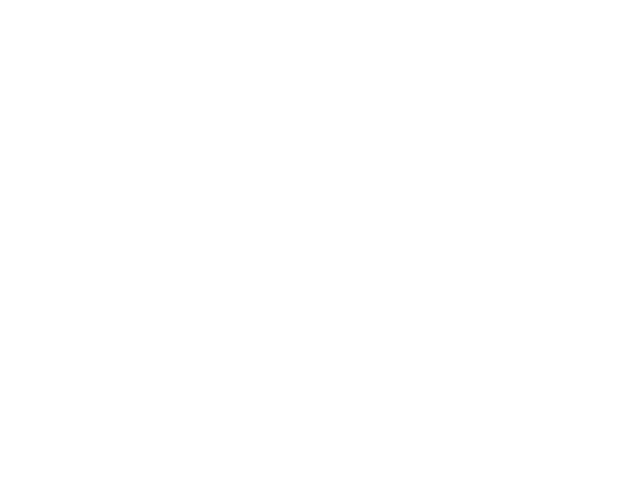

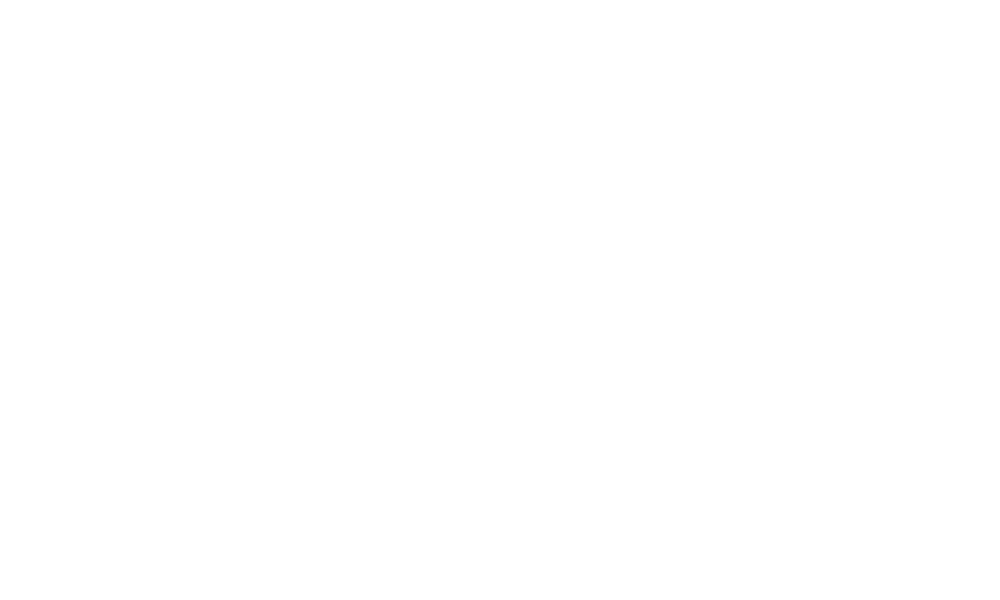

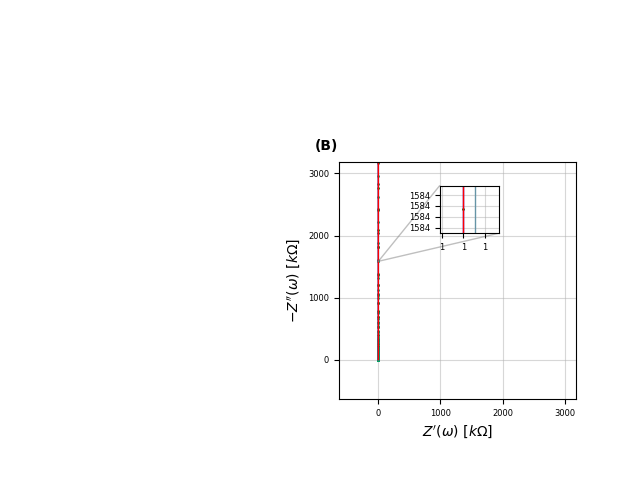

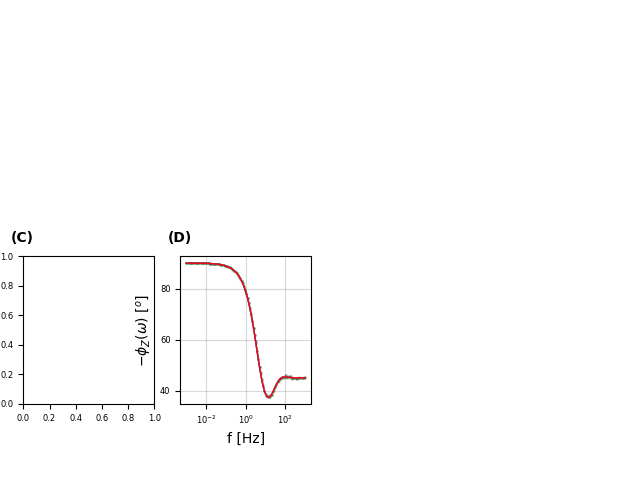

In [78]:
plt.close()
#plotter_for_three(freq=freq,circuit0=c0,zin1=z1,zin2=z2,zin3=z3,circuitg1=cg1,circuitg2=cg2,circuitg3=cg3,wt="prop")
#plotter_for_three2(freq=freq,circuit0=c0,zin1=z1,zin2=z2,zin3=z3,circuitg1=cg1,circuitg2=cg2,circuitg3=cg3,wt="prop")
plotter_for_three2(freq=freq,circuit0=c0,zin1=z1,zin2=z2,zin3=z3,circuitg1=cg1,circuitg2=cg2,circuitg3=cg3,wt="prop")

plt.show()